In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
import datetime

In [11]:
rawLinks = pd.read_csv('MOCA-data/10090.protein.links.full.v11.0.CombinedScore.HighConfidence.csv')
rawAlias = pd.read_csv('MOCA-data/10090.protein.aliases.v11.0.UniProt.csv')
print('Here')
print(str(datetime.datetime.now()))

Here
2019-03-25 13:50:12.056799


In [6]:
#build a map of proteinId in rawLinks to gene product names
proteinIdToAlias = {}
aliasToProteinId = {}
duplicatedAliases = []
for val in list(zip(rawAlias.string_protein_id, rawAlias.alias)):
    if val[1] in aliasToProteinId:
        duplicatedAliases.append(str(val[1]))
        aliasToProteinId[val[1]].append(val[0])
    else:
        aliasToProteinId[val[1]] = [val[0]]
    
    if not val[0] in proteinIdToAlias: #the alias file has lots of duplicates!
        proteinIdToAlias[val[0]]=[val[1]]
    else:
        proteinIdToAlias[val[0]].append(val[1])
        
print('Here')
print('There are ', len(duplicatedAliases), ' aliases which point to multiple protein ids')
print(str(datetime.datetime.now()))

Here
There are  0  aliases which point to multiple protein ids
2019-03-25 13:45:06.007432


In [21]:
#build the list of links mapped to gene product name
links = list(zip(rawLinks.protein1, rawLinks.protein2, rawLinks.combined_score))
links = [list(elem) for elem in links]
print('Here')
print(str(datetime.datetime.now()))

Here
2019-03-25 13:53:18.092903


In [45]:
#filter links where both in and out are in the dataset
rawGeneList = pd.read_csv('MOCA-data/41586_2019_933_MOESM4_ESM.csv')
acceptableGeneList = rawGeneList.mgi.map(lambda x: x.upper())
acceptableGeneSet = set(acceptableGeneList)

print(str(datetime.datetime.now()))
print('There are ', len(acceptableGeneSet), ' acceptable gene products')

print('Determining gene products which have multiple protein ids')
problematic = list(acceptableGeneSet.intersection(duplicatedAliases))
print('There are ', len(problematic), ' aliases which have multiple protein ids');

filteredLinks = []
for link in links:
    aliasesOfStart = proteinIdToAlias[link[0]]
    aliasesOfEnd = proteinIdToAlias[link[1]]
    
    if len(aliasesOfStart) == 0:
        print("Empty start" + link[0])
        
    if len(aliasesOfEnd) == 0:
        print("Empty end" + link[0])
        
        
    startIsAcceptable = not acceptableGeneSet.isdisjoint(aliasesOfStart)
    endIsAcceptable = not acceptableGeneSet.isdisjoint(aliasesOfEnd)
    
    if startIsAcceptable and endIsAcceptable:
        filteredLinks.append(link)
        
print('There are ', len(filteredLinks), ' filtered links')
print(str(datetime.datetime.now()))

2019-03-25 14:14:04.809624
There are  2267  acceptable gene products
Determining gene products which have multiple protein ids
There are  0  aliases which have multiple protein ids
There are  13700  filtered links
2019-03-25 14:14:05.525175


In [47]:
#transform filtered links to not use protein ids but rather aliases (or a combination)
print('Transform the filtered links...')
print(str(datetime.datetime.now()))
for geneProduct in acceptableGeneSet:
    if not geneProduct in aliasToProteinId:
        continue
        
    proteinIds = aliasToProteinId[geneProduct]
    for proteinId in proteinIds:
        for link in filteredLinks:
            if link[0] == proteinId:
                link[0] = geneProduct
            
            if link[1] == proteinId:
                link[1] = geneProduct

print('Done...')
print(str(datetime.datetime.now()))

Transform the filtered links...
2019-03-25 14:14:28.533851
Done...
2019-03-25 14:14:32.660652


In [48]:
print(str(datetime.datetime.now()))
G = nx.DiGraph()
G.add_weighted_edges_from(filteredLinks)
nx.write_gml(G, 'out/gephi/moca.gml')
print('Now open out/gephi/moca.gml')
print(str(datetime.datetime.now()))

2019-03-25 14:14:35.237088
Now open out/gephi/moca.gml
2019-03-25 14:14:35.335495


(array([1054.,  814.,  640.,  698.,  558.,  550., 3922., 2506., 1248.,
        1710.]),
 array([701. , 730.8, 760.6, 790.4, 820.2, 850. , 879.8, 909.6, 939.4,
        969.2, 999. ]),
 <a list of 10 Patch objects>)

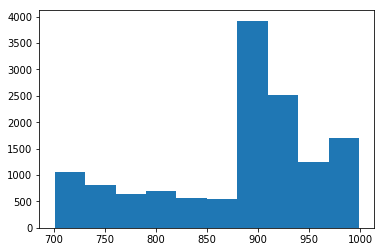

In [49]:
weights = []
for link in filteredLinks:
    weights.append(link[2])
    
plt.hist(weights)